In [41]:
import pandas as pd
import evds as ev
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot
from arch.unitroot import ADF, KPSS
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error

In [3]:
with open("/Users/neseuygun/Desktop/evds_api_key.txt") as file:
    api = file.read()

evds = ev.evdsAPI(api)
data = evds.get_data(["TP.MK.LON.YTL"], startdate="01-01-2000", enddate="01-01-2024")

In [4]:
data["Tarih"] = pd.date_range("01.01.2000", periods=len(data["Tarih"]), freq="M")
data.rename(columns={"Tarih":"Date", "TP_MK_LON_YTL":"Gold_Price"}, inplace=True)
data.set_index("Date", inplace=True)

In [5]:
data.head()

,Gold_Price
Date,
2000-01-31,284.3
2000-02-29,300.7
2000-03-31,285.3
2000-04-30,279.4
2000-05-31,275.9


In [6]:
data.isnull().sum()

Gold_Price    0
dtype: int64

In [7]:
# Split data as train and test set
train = data.iloc[:-12]
test = data.iloc[-12:]

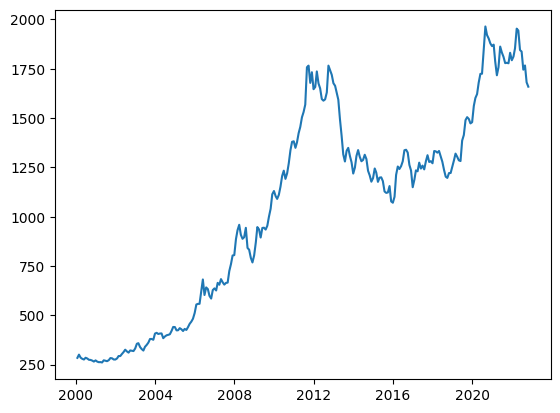

In [8]:
plt.plot(train)
plt.show()

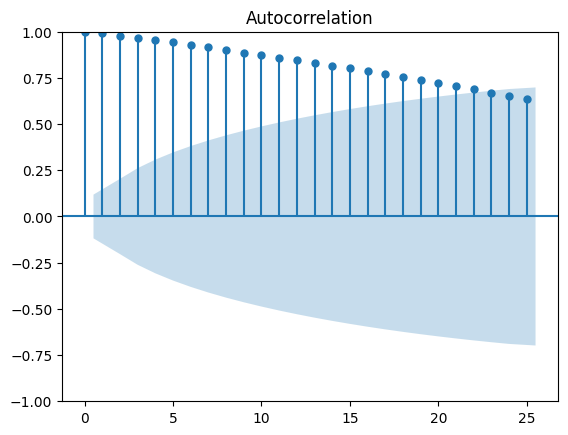

In [9]:
# check if the data is stationary and include seasonality
acf = plot_acf(train)
plt.show()

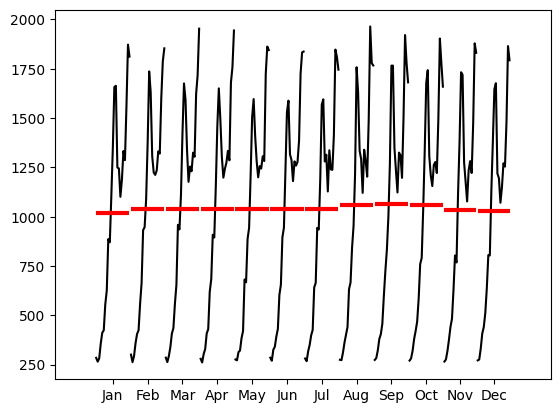

In [10]:
month_plot(train)
plt.show()

there is a trend because there is a gradually decreasing structure in acf plot.
at the same time in month plot all month mean is very similar.
So there is no seasonality.

In [11]:
# prove if there is a trend and seasonality statistically
adf = ADF(train)
kpss = KPSS(train)
print(adf)
print(kpss)

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.016
P-value                         0.747
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
    KPSS Stationarity Test Results   
Test Statistic                  2.162
P-value                         0.000
Lags                               10
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


/Users/neseuygun/miniconda3/lib/python3.11/site-packages/arch/unitroot/unitroot.py:785: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._stat = stat = resols.tvalues[0]


As we see the statistical results above, the process contains a unit root. so the series is not stationary.

In [12]:
# we need ta take difference with its lag to make stationary the data.
datadiff = train.diff().dropna()
adf = ADF(datadiff)
kpss = KPSS(datadiff)
print(adf)
print(kpss)

   Augmented Dickey-Fuller Results   
Test Statistic                -13.191
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
    KPSS Stationarity Test Results   
Test Statistic                  0.106
P-value                         0.556
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


/Users/neseuygun/miniconda3/lib/python3.11/site-packages/arch/unitroot/unitroot.py:785: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._stat = stat = resols.tvalues[0]


when we look at the adf and kpss results we can see our series is stationary.

In [17]:
# model setup
model = auto_arima(train, trace=True, seasonal=False)
model

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2796.810, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2807.246, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2796.324, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2795.485, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2809.321, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2797.484, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2797.484, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2799.473, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2796.333, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.354 seconds


ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

In [18]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  274
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1394.742
Date:                Sun, 24 Dec 2023   AIC                           2795.485
Time:                        17:44:43   BIC                           2806.313
Sample:                    01-31-2000   HQIC                          2799.831
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.0469      3.064      1.647      0.100      -0.959      11.053
ma.L1          0.2274      0.054      4.193      0.000       0.121       0.334
sigma2      1603.2364     99.137     16.172      0.0

In [20]:
# we need to examine whether the residuals are in the white noise process
error = model.resid()
error

Date
2000-01-31    279.253094
2000-02-29     11.251454
2000-03-31    -22.879924
2000-04-30     -5.757078
2000-05-31     -7.237890
                 ...    
2022-06-30      8.963071
2022-07-31    -98.865152
2022-08-31     38.925506
2022-09-30    -99.558754
2022-10-31     -4.396766
Length: 274, dtype: float64

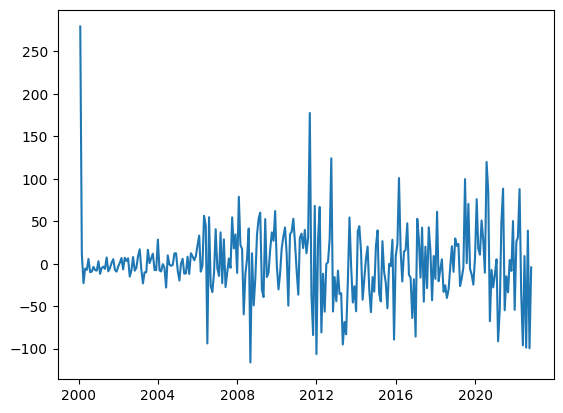

In [ ]:
plt.plot(error)
plt.show()
# It seems the series error has white noise process

In [29]:
# Let's prove if the series is in white noise process
ACF = sm.tsa.stattools.acf(error, qstat=True, nlags=10) # looking only 10 lags values

otocorr = {
    "Lags": range(1,11),
    "ACF": np.round(ACF[0][1:],3),
    "Prob": np.round(ACF[2], 3)
}

df = pd.DataFrame(data=otocorr)


In [30]:
df

,Lags,ACF,Prob
0,1,0.006,0.915
1,2,-0.018,0.952
2,3,-0.027,0.959
3,4,-0.019,0.982
4,5,0.093,0.724
5,6,0.055,0.718
6,7,-0.038,0.767
7,8,-0.116,0.443
8,9,-0.009,0.541
9,10,0.028,0.613


As we see looking at p values above, it is not meaningfull so we can say the series error has white noise process.

In [32]:
# Second method examine the white noise process
wn = acorr_ljungbox(error)
wn

,lb_stat,lb_pvalue
1,0.011304,0.915329
2,0.097817,0.952268
3,0.303631,0.959344
4,0.404390,0.982116
5,2.843665,0.724073
6,3.697086,0.717590
7,4.108745,0.767170
8,7.904525,0.442852
9,7.928167,0.541401
10,8.159404,0.613270


In [33]:
# Lets setup model and predict next 12 months
prediction, confidence_interval = model.predict(12, return_conf_int=True)

print(prediction)
print(confidence_interval)

2022-11-30    1663.227060
2022-12-31    1668.273967
2023-01-31    1673.320873
2023-02-28    1678.367779
2023-03-31    1683.414685
2023-04-30    1688.461591
2023-05-31    1693.508498
2023-06-30    1698.555404
2023-07-31    1703.602310
2023-08-31    1708.649216
2023-09-30    1713.696122
2023-10-31    1718.743028
Freq: M, dtype: float64
[[1584.74925074 1741.70487016]
 [1544.02788962 1792.52004363]
 [1516.10952242 1830.53222318]
 [1493.99389329 1862.74166466]
 [1475.39533327 1891.43403704]
 [1459.22291267 1917.70026999]
 [1444.85473656 1942.16225844]
 [1431.89641946 1965.2143879 ]
 [1420.07923337 1987.12538634]
 [1409.21031419 2008.08811787]
 [1399.14568591 2028.2465585 ]
 [1389.77449188 2047.71156488]]


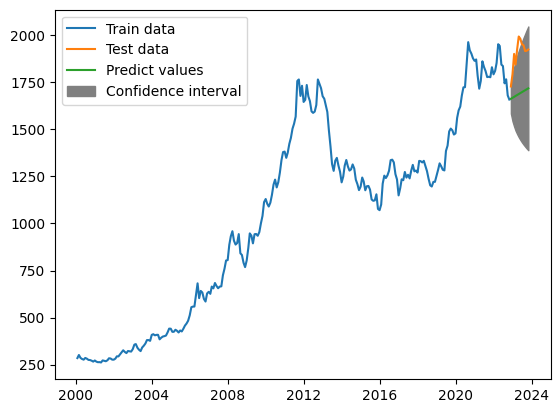

In [37]:
# Now lets plot the predictions
plt.plot(train, label="Train data")
plt.plot(test, label="Test data")
plt.plot(prediction, label="Predict values")
plt.fill_between(prediction.index, confidence_interval[:,0], confidence_interval[:,1], color="gray", label="Confidence interval")
plt.legend()
plt.show()


In [39]:
#Lets compare taking diffirentiation of first lag and second lag values results
model = auto_arima(train, trace=True, seasonal=False)
model2 = auto_arima(train, trace=True, seasonal=False, d=2)

print(model)
print(model2)

#It seems first model give less error value so it works better.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2796.810, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2807.246, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2796.324, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2795.485, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2809.321, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2797.484, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2797.484, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2799.473, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2796.333, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.370 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2920.279, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2884.950, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2805.190

In [40]:
# lets check if residuals are in the white noise process
error = model.resid()
error2 = model2.resid()

print(acorr_ljungbox(error))
print(acorr_ljungbox(error2))

     lb_stat  lb_pvalue
1   0.011304   0.915329
2   0.097817   0.952268
3   0.303631   0.959344
4   0.404390   0.982116
5   2.843665   0.724073
6   3.697086   0.717590
7   4.108745   0.767170
8   7.904525   0.442852
9   7.928167   0.541401
10  8.159404   0.613270
      lb_stat  lb_pvalue
1    2.409426   0.120607
2    3.386298   0.183939
3    4.547330   0.208107
4    4.863695   0.301571
5    6.717213   0.242535
6    7.414729   0.284189
7    8.814888   0.266221
8   14.796330   0.063229
9   15.368356   0.081302
10  15.551441   0.113213


both of models are in the white noise process

In [44]:
prediction1, ci = model.predict(12, return_conf_int=True)
prediction2, ci = model2.predict(12, return_conf_int=True)

rmse1 = np.sqrt(mean_squared_error(test, prediction1))
rmse2 = np.sqrt(mean_squared_error(test, prediction2))

print(rmse1)
print(rmse2)

221.56035472491993
284.7106592618921


As we see the both results, model 1 that we take lag1 value gives better prediction result because error is less.